In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder ### available? Imho should be, like cmon
from sklearn.model_selection import train_test_split ###hopefully we're allowed to use this too
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

from preprocessing import Preprocessor

In [2]:
prep = Preprocessor()

# 1. Bank data

Missing values: Categorical with 'unknown'. Will be treated as a separate class

In [3]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep=';')
bank_target = (bank_df['y'] == 'yes').astype(int)
bank_df = bank_df.drop('y', axis=1)
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


#### Train test division

In [4]:
bank_prep = Preprocessor()
bank_df_train, bank_df_test, bank_y_train, bank_y_test = bank_prep.train_test_split(bank_df, bank_target)
print(bank_df_train.shape, bank_df_test.shape)

(30891, 20) (10297, 20)


#### One Hot Encoding

In [5]:
bank_df_train_ohe = bank_prep.one_hot_encoding_fit_transform(bank_df_train)

In [6]:
bank_df_train_ohe

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_mar,month_dec,month_nov,month_aug,day_of_week_fri,day_of_week_wed,day_of_week_mon,day_of_week_thu,poutcome_success,poutcome_failure
38717,41,95,1,3,1,-3.4,92.649,-30.1,0.715,5017.5,...,0,0,1,0,0,0,0,0,1,0
27863,60,194,1,999,0,-1.8,92.843,-50.0,1.602,5099.1,...,1,0,0,0,0,1,0,0,0,0
39256,38,422,1,10,1,-1.8,93.369,-34.8,0.649,5008.7,...,1,0,0,0,1,0,0,0,1,0
28223,31,84,1,999,1,-1.8,93.075,-47.1,1.453,5099.1,...,0,0,0,0,0,0,0,0,0,1
37582,29,260,3,999,0,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13334,37,362,1,999,0,1.4,93.918,-42.7,4.962,5228.1,...,0,0,0,0,0,1,0,0,0,0
2895,34,48,1,999,0,1.1,93.994,-36.4,4.859,5191.0,...,0,0,0,0,0,1,0,0,0,0
8618,29,251,1,999,0,1.4,94.465,-41.8,4.864,5228.1,...,0,0,0,0,0,1,0,0,0,0
35282,32,212,3,999,0,-1.8,92.893,-46.2,1.250,5099.1,...,0,0,0,0,1,0,0,0,0,0


In [7]:
bank_df_test_ohe = bank_prep.one_hot_encoding_transform(bank_df_test)

#### Removing almost collinear columns

In [8]:
bank_df_train_ohe_rc = bank_prep.remove_multicollinearity_fit_transform(bank_df_train_ohe)

/home/pawel/.local/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping housing_yes with vif=inf
Dropping nr.employed with vif=81789.3428423048
Dropping cons.price.idx with vif=1577.6800612923535
Dropping pdays with vif=278.6884869597688
Dropping marital_married with vif=208.6751149054179
Dropping euribor3m with vif=104.74275262508239
Dropping cons.conf.idx with vif=99.11467546435752
Dropping loan_no with vif=30.824847421307933
Dropping age with vif=21.23540143314675
Dropping job_admin. with vif=10.810408474780031
43  features left in dataset


In [9]:
bank_df_test_ohe_rc = bank_prep.remove_multicollinearity_transform(bank_df_test_ohe)

In [10]:
bank_df_test_ohe_rc.shape

(10297, 43)

# 2. Diabetic Retinopathy
No missing values

In [2]:
from scipy.io import arff
import pandas as pd
data = arff.loadarff('data/messidor_features.arff')
retinopathy_df = pd.DataFrame(data[0])
retinopathy_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,b'0'
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,b'0'
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,b'1'
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,b'0'
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,b'1'


In [3]:
retinopathy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1151 non-null   float64
 1   1       1151 non-null   float64
 2   2       1151 non-null   float64
 3   3       1151 non-null   float64
 4   4       1151 non-null   float64
 5   5       1151 non-null   float64
 6   6       1151 non-null   float64
 7   7       1151 non-null   float64
 8   8       1151 non-null   float64
 9   9       1151 non-null   float64
 10  10      1151 non-null   float64
 11  11      1151 non-null   float64
 12  12      1151 non-null   float64
 13  13      1151 non-null   float64
 14  14      1151 non-null   float64
 15  15      1151 non-null   float64
 16  16      1151 non-null   float64
 17  17      1151 non-null   float64
 18  18      1151 non-null   float64
 19  Class   1151 non-null   object 
dtypes: float64(19), object(1)
memory usage: 180.0+ KB


In [4]:
for c in retinopathy_df.columns:
    print("column name: ",c,"number of unique values: ",len(retinopathy_df[c].unique()),"Number of nulls",retinopathy_df.isna().sum().sum())

column name:  0 number of unique values:  2 Number of nulls 0
column name:  1 number of unique values:  2 Number of nulls 0
column name:  2 number of unique values:  110 Number of nulls 0
column name:  3 number of unique values:  104 Number of nulls 0
column name:  4 number of unique values:  99 Number of nulls 0
column name:  5 number of unique values:  91 Number of nulls 0
column name:  6 number of unique values:  84 Number of nulls 0
column name:  7 number of unique values:  69 Number of nulls 0
column name:  8 number of unique values:  1141 Number of nulls 0
column name:  9 number of unique values:  1141 Number of nulls 0
column name:  10 number of unique values:  1130 Number of nulls 0
column name:  11 number of unique values:  1032 Number of nulls 0
column name:  12 number of unique values:  795 Number of nulls 0
column name:  13 number of unique values:  579 Number of nulls 0
column name:  14 number of unique values:  415 Number of nulls 0
column name:  15 number of unique value

description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set#)

Target: `Class`

In [5]:
X_retinopathy=retinopathy_df.drop(columns='Class')
y_retinopathy=(retinopathy_df['Class'] == b'1').astype(int)

There are no categorical variables.

#### Train test split

In [6]:
ret_prep = Preprocessor()
ret_df_train, ret_df_test, ret_y_train, ret_y_test = ret_prep.train_test_split(X_retinopathy, y_retinopathy)

#### Collinearity detection

Pair correlations insight:

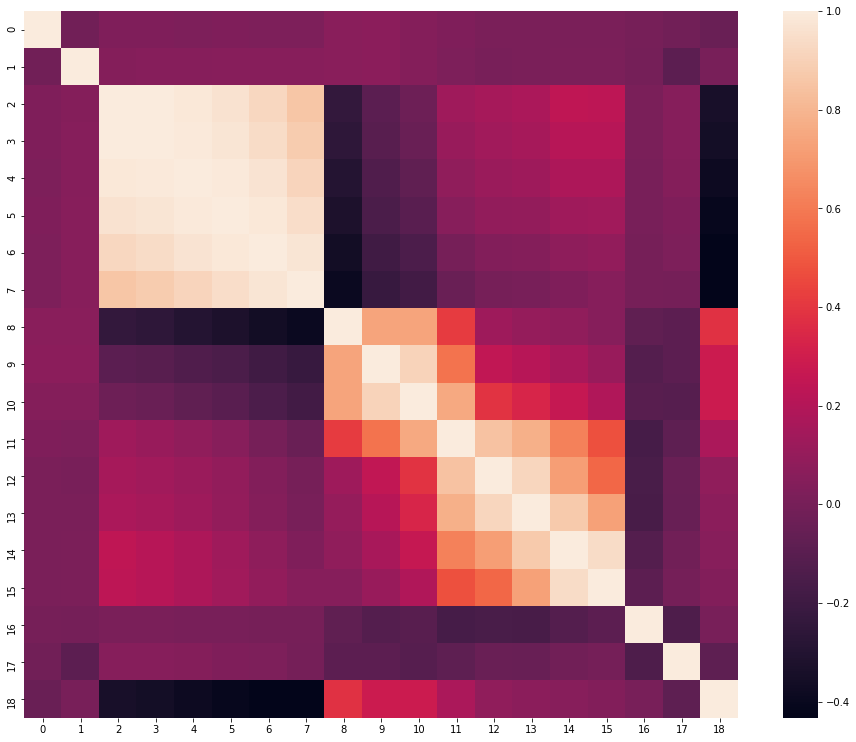

In [7]:
ret_prep.plot_corr(ret_df_train)

In [8]:
ret_df_train_rc = ret_prep.remove_multicollinearity_fit_transform(ret_df_train)

Dropping 4 with vif=1565.7570138833469
Dropping 3 with vif=1026.4770188591658
Dropping 5 with vif=533.603809887562
Dropping 0 with vif=186.9203367718396
Dropping 6 with vif=169.15178703948163
Dropping 16 with vif=49.02945654048401
Dropping 10 with vif=29.583043148163632
Dropping 14 with vif=28.275238095684532
Dropping 2 with vif=15.176266706192704
Dropping 12 with vif=13.014782969996318
Dropping 17 with vif=11.336632622576108
8  features left in dataset


In [9]:
ret_df_test_rc = ret_prep.remove_multicollinearity_transform(ret_df_test)

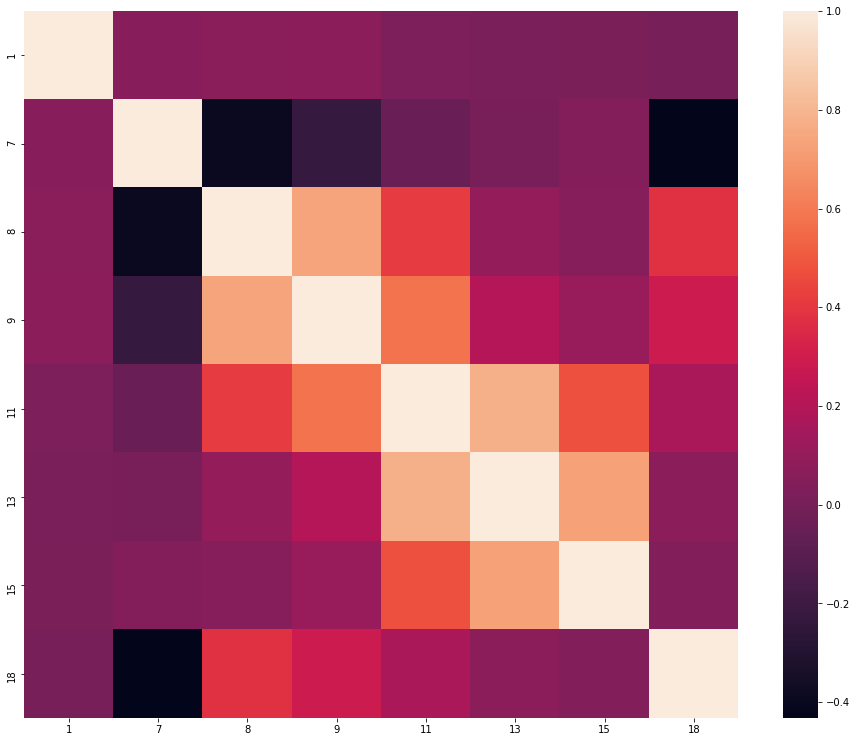

In [10]:
ret_prep.plot_corr(ret_df_train_rc)

#### Results without VIF reduction

In [11]:
model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train, ret_y_train)
print(ret_df_train.shape)
print('Train acc', model.score(ret_df_train, ret_y_train))
print('Test acc', model.score(ret_df_test, ret_y_test))

(863, 19)
Train acc 0.7543453070683661
Test acc 0.7395833333333334


#### Results with VIF reduction

In [12]:
model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train_rc, ret_y_train)
print(ret_df_train_rc.shape)
print('Train acc', model.score(ret_df_train_rc, ret_y_train))
print('Test acc', model.score(ret_df_test_rc, ret_y_test))

(863, 8)
Train acc 0.6407879490150638
Test acc 0.6388888888888888


#### Results with VIF reduction and StandardScaler

In [13]:
st_sc = StandardScaler()
ret_df_train_rc_scaled = st_sc.fit_transform(ret_df_train_rc)

model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train_rc_scaled, ret_y_train)
print(ret_df_train_rc_scaled.shape)
print('Train acc', model.score(ret_df_train_rc_scaled, ret_y_train))
print('Test acc', model.score(st_sc.transform(ret_df_test_rc), ret_y_test))


(863, 8)
Train acc 0.6442641946697567
Test acc 0.6388888888888888


#### Results with feature selection based on correlation matrix

In [14]:
ret_df_train_dc=ret_prep.DeleteCorrelated(ret_df_train)
ret_df_test_dc = ret_df_test.loc[:, ret_df_train_dc.columns]
model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train_dc, ret_y_train)
print(ret_df_train_dc.shape)
print('Train acc', model.score(ret_df_train_dc, ret_y_train))
print('Test acc', model.score(ret_df_test_dc, ret_y_test))

(863, 8)
Train acc 0.6373117033603708
Test acc 0.6597222222222222


# 3. Breast Cancer Wisconsin

No missing values. Special treatment: columns `id` and `Unnamed: 32`

In [15]:
wdbc_df=pd.read_csv('data/wdbc.csv')

wdbc_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [16]:
wdbc_df['Unnamed: 32'].any()

False

In [17]:
y_wdbc=wdbc_df['diagnosis']=="M"
X_wdbc=wdbc_df.drop(columns=["id","diagnosis","Unnamed: 32"])

X_wdbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

As we can see all features are non-null numeric type variables. Which means that in this case one-hot-encoding won't be needed. The only things left to do is to remove collinear and multicollinear ones (maybe remove some outliers? from data) and split data into training and testing sets.

Correlation matrix showing that we should probably remove a fair number of variables

In [18]:
prep_wdbc = Preprocessor()

In [21]:
wdbc_train, wdbc_test, y_wdbc_train, y_wdbc_test = prep_wdbc.train_test_split(X_wdbc, y_wdbc)

Removal of variables based only on correlation

In [22]:
X_wdbc_cleaned_corr = prep_wdbc.DeleteCorrelated(wdbc_train,0.8)
X_wdbc_cleaned_corr.columns

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concave points_se', 'symmetry_se',
       'symmetry_worst'],
      dtype='object')

Removal of variables using Variance Inflation Factor (VIF)

In [24]:
X_wdbc_cleaned_train = prep_wdbc.remove_multicollinearity_fit_transform(wdbc_train)
X_wdbc_cleaned_train.tail()

Dropping radius_mean with vif=65226.53246601422
Dropping perimeter_mean with vif=7715.053991493582
Dropping radius_worst with vif=4091.0767866060273
Dropping perimeter_worst with vif=628.4610786270873
Dropping fractal_dimension_mean with vif=508.8573848538166
Dropping smoothness_worst with vif=412.1528152711056
Dropping texture_worst with vif=295.6729056238775
Dropping fractal_dimension_worst with vif=218.9428702127479
Dropping symmetry_worst with vif=176.25775900763793
Dropping concavity_mean with vif=160.4170076895063
Dropping radius_se with vif=107.05405397483312
Dropping concave points_worst with vif=100.73853011084147
Dropping compactness_worst with vif=85.45410872392202
Dropping smoothness_mean with vif=83.76943830899155
Dropping area_mean with vif=61.49411436540814
Dropping compactness_mean with vif=55.41925213075954
Dropping perimeter_se with vif=43.838264409113876
Dropping symmetry_mean with vif=36.0302412798298
Dropping texture_mean with vif=22.909591120430356
Dropping compac

,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,concavity_worst
424,1.7470,43.52,0.013070,0.006021,0.03100,0.004225,0.02085
410,1.5550,13.66,0.005391,0.011630,0.01341,0.001659,0.18110
429,0.8836,23.24,0.007337,0.005383,0.01940,0.001180,0.03469
381,1.0310,11.68,0.005296,0.017230,0.01880,0.001941,0.15530
443,2.5420,13.12,0.010720,0.019930,0.01717,0.004492,0.03986


In [26]:
model = LogisticRegression(max_iter=1e20)
model.fit(X_wdbc_cleaned_train, y_wdbc_train)
print(model.score(X_wdbc_cleaned_train, y_wdbc_train))
model.score(prep_wdbc.remove_multicollinearity_transform(wdbc_test), y_wdbc_test)

0.9225352112676056


0.8881118881118881

## 4. Etherneum frauds

#TODO

Should be some numeric columns treated as categorical? 

In [29]:
eth_prep = Preprocessor()
etherneum_df=pd.read_csv('data/transaction_dataset.csv')

etherneum_df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [31]:
for c in etherneum_df.columns:
    if(len(etherneum_df[c].unique())<10):
        print(c,etherneum_df[c].unique())

FLAG [0 1]
min value sent to contract [0.   0.02 0.01]
max val sent to contract [0.       0.02     0.01     0.046029]
avg value sent to contract [0.       0.02     0.01     0.023014]
total ether sent contracts [0.         0.02       0.01       0.04602871]
 ERC20 uniq sent addr.1 [ 0.  1.  3.  2. nan]
 ERC20 avg time between sent tnx [ 0. nan]
 ERC20 avg time between rec tnx [ 0. nan]
 ERC20 avg time between rec 2 tnx [ 0. nan]
 ERC20 avg time between contract tnx [ 0. nan]
 ERC20 min val sent contract [ 0. nan]
 ERC20 max val sent contract [ 0. nan]
 ERC20 avg val sent contract [ 0. nan]


In [32]:
etherneum_df[' ERC20 uniq sent addr.1'].fillna(0) # does not work inplace
etherneum_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,9841.0,4.920000e+03,2.840996e+03,0.00,2460.000000,4.920000e+03,7380.000000,9.840000e+03
Index,9841.0,1.815050e+03,1.222622e+03,1.00,821.000000,1.641000e+03,2601.000000,4.729000e+03
FLAG,9841.0,2.214206e-01,4.152241e-01,0.00,0.000000,0.000000e+00,0.000000,1.000000e+00
Avg min between sent tnx,9841.0,5.086879e+03,2.148655e+04,0.00,0.000000,1.734000e+01,565.470000,4.302877e+05
Avg min between received tnx,9841.0,8.004851e+03,2.308171e+04,0.00,0.000000,5.097700e+02,5480.390000,4.821755e+05
Time Diff between first and last (Mins),9841.0,2.183333e+05,3.229379e+05,0.00,316.930000,4.663703e+04,304070.980000,1.954861e+06
Sent tnx,9841.0,1.159317e+02,7.572264e+02,0.00,1.000000,3.000000e+00,11.000000,1.000000e+04
Received Tnx,9841.0,1.637009e+02,9.408366e+02,0.00,1.000000,4.000000e+00,27.000000,1.000000e+04
Number of Created Contracts,9841.0,3.729702e+00,1.414456e+02,0.00,0.000000,0.000000e+00,0.000000,9.995000e+03
Unique Received From Addresses,9841.0,3.036094e+01,2.986211e+02,0.00,1.000000,2.000000e+00,5.000000,9.999000e+03


In [33]:
to_drop=['Unnamed: 0',
         'Index',
         'Address',
         ' ERC20 avg time between sent tnx',
         ' ERC20 avg time between rec tnx',
         ' ERC20 avg time between rec 2 tnx',
         ' ERC20 avg time between contract tnx',
         ' ERC20 min val sent contract',
         ' ERC20 max val sent contract',
         ' ERC20 avg val sent contract']
etherneum_df.drop(columns=to_drop,inplace=True)

In [34]:
for c in etherneum_df.columns:
    if etherneum_df[c].dtype=='O':
        print(c,len(etherneum_df[c].unique()))

 ERC20 most sent token type 306
 ERC20_most_rec_token_type 468


In [35]:
y_eth=etherneum_df['FLAG']
X_eth_raw=etherneum_df.drop(columns='FLAG')

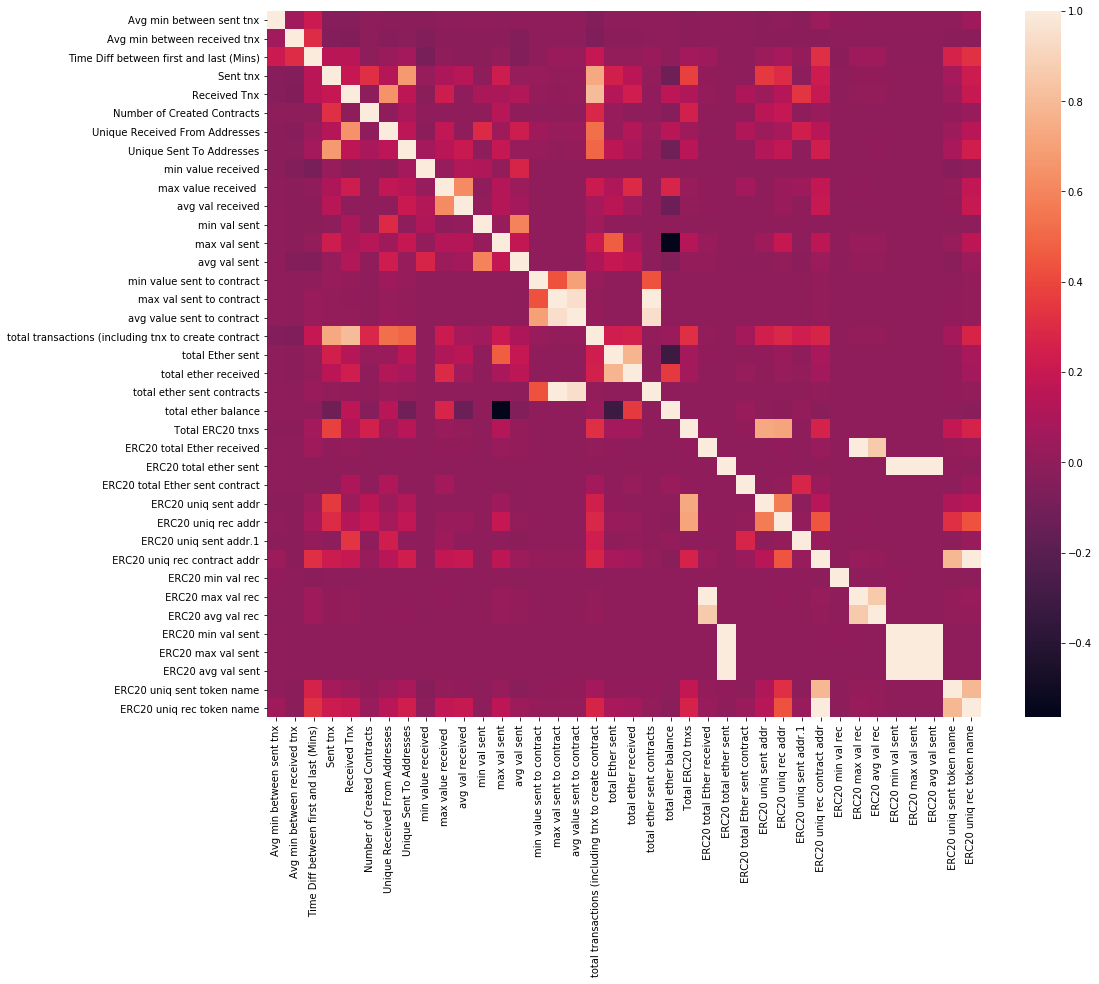

In [36]:
eth_prep.plot_corr(X_eth_raw)

In [37]:
eth_df_train, eth_df_test, eth_y_train, eth_y_test = eth_prep.train_test_split(X_eth_raw, y_eth)

In [40]:
eth_df_train

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
9020,4645.36,2235.01,34226.52,4,7,0,5,4,0.000000,9.998000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8213,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8962,7437.77,89.42,112192.57,15,7,0,7,15,0.500000,3.016449,...,0.000000,1.337000,0.668500,0.000000,0.000000,0.000000,0.0,2.0,,Blockwell say NOTSAFU
9452,341.92,4038.81,21561.73,4,5,0,5,2,0.500000,1.529743,...,1.337000,1.337000,1.337000,0.000000,0.000000,0.000000,0.0,1.0,,Blockwell say NOTSAFU
8695,0.00,29020.27,174121.62,0,6,1,4,0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7592,8313.48,0.00,16626.97,2,1,0,1,2,0.493750,0.493750,...,0.000000,0.000001,0.000000,0.000001,0.000001,0.000001,1.0,1.0,Humaniq,Humaniq
5998,23.70,590.11,509889.90,823,831,0,1,2,0.100181,4.590070,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0
435,155.10,0.00,310.20,2,1,0,1,2,101.000000,101.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0
4677,6270.16,944.23,165856.75,26,3,0,1,8,0.010000,0.010000,...,0.000000,8393.471756,489.528352,0.000000,8393.471756,548.271755,7.0,7.0,Reputation,Reputation


In [39]:
X_eth_cleaned = eth_prep.remove_multicollinearity_fit_transform(eth_df_train.drop(columns=[' ERC20_most_rec_token_type',' ERC20 most sent token type']))

MissingDataError: exog contains inf or nans

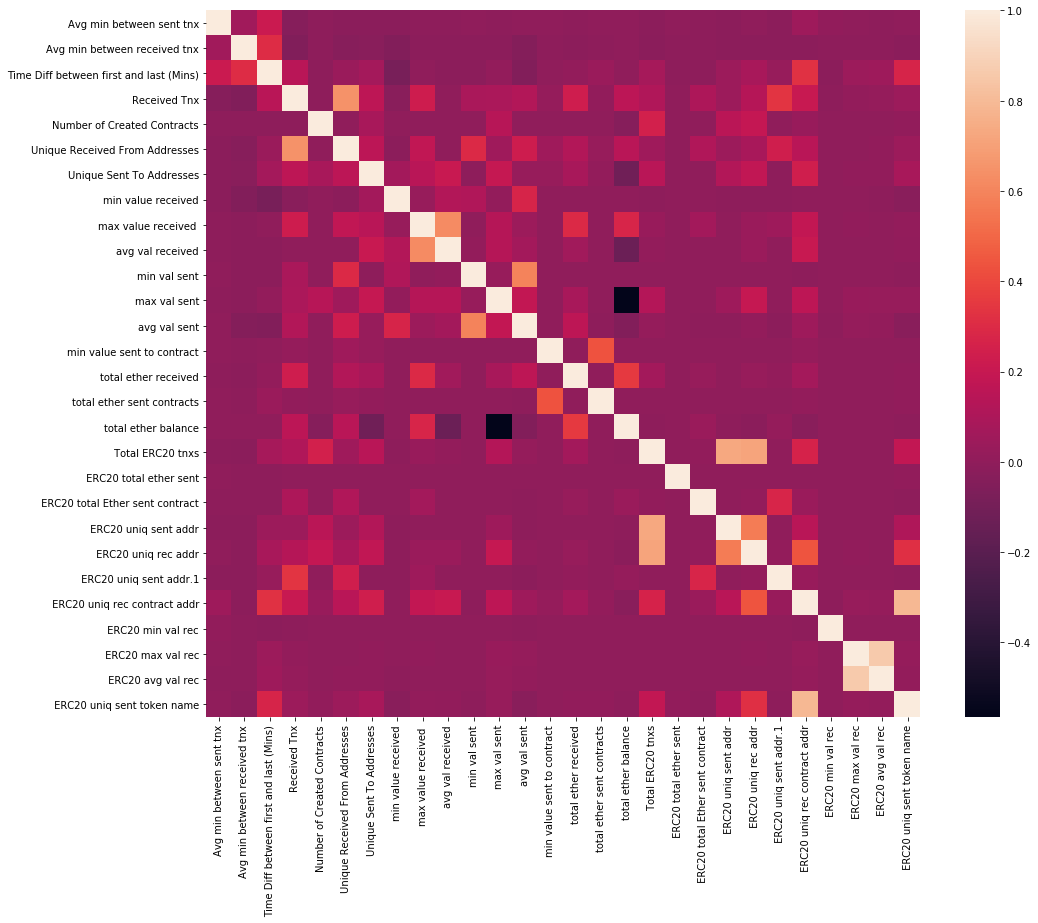

In [37]:
eth_prep.plot_corr(X_eth_cleaned)
#one could still consider droping some of the variables because of high correlation

#### Results when using only numerical features
without VIF reduction

In [38]:
X_eth_no_categorical=X_eth_raw.drop(columns=[' ERC20 most sent token type',' ERC20_most_rec_token_type']).fillna(0)
X_train, X_test, y_train, y_test=train_test_split(X_eth_no_categorical,
                                                  y_eth,
                                                  test_size=0.2
                                                 )

model0 = LogisticRegression(max_iter=1e20)
model0.fit(X_train, y_train)
print(X_train.shape[1])
model0.score(X_test, y_test)

38


0.80802437785678

#### Results when using only numerical features
with VIF reduction

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X_eth_cleaned,y_eth,test_size=0.2)

model1 = LogisticRegression(max_iter=1e20)
model1.fit(X_train, y_train)
print(X_eth_cleaned.shape[1])
model1.score(X_test, y_test)

28


0.7790756729304216

In [40]:
X_eth_raw_categorical=X_eth_raw[[' ERC20 most sent token type',' ERC20_most_rec_token_type']].fillna("unknown")
encoder=OneHotEncoder()
encoder.fit(X_eth_raw_categorical)
X_eth_cat_enc=encoder.transform(X_eth_raw_categorical)

In [41]:
X_eth_enc = X_eth_cleaned.join(pd.DataFrame(X_eth_cat_enc.toarray(),columns=np.concatenate(encoder.categories_)))

ciekawostka:

#### Results when using only categorical features encoded

In [63]:
X_train_cat_only, X_test_cat_only, y_train_cat_only, y_test_cat_only=\
                                train_test_split(pd.DataFrame(X_eth_cat_enc.toarray(),
                                                               columns=np.concatenate(encoder.categories_)),
                                                  y_eth,
                                                  test_size=0.2
                                                 )

model2_cat_only = LogisticRegression(max_iter=1e20)
model2_cat_only.fit(X_train_cat_only, y_train_cat_only)
print(X_train_cat_only.shape)
print(model2_cat_only.score(X_train_cat_only, y_train_cat_only))
model2_cat_only.score(X_test_cat_only, y_test_cat_only)

(7872, 774)
0.9870426829268293


0.9832402234636871

In [105]:
from sklearn.preprocessing import StandardScaler

In [106]:
X_train_cat_only, X_test_cat_only, y_train_cat_only, y_test_cat_only=\
                                train_test_split(pd.DataFrame(X_eth_cat_enc.toarray(),
                                                               columns=np.concatenate(encoder.categories_)),
                                                  y_eth,
                                                  test_size=0.2
                                                 )

ss = StandardScaler()
X_train_cat_only = ss.fit_transform(X_train_cat_only)


model2_cat_only = LogisticRegression(max_iter=1e20)
model2_cat_only.fit(X_train_cat_only, y_train_cat_only)
print(X_train_cat_only.shape)
print(model2_cat_only.score(X_train_cat_only, y_train_cat_only))
model2_cat_only.score(ss.transform(X_test_cat_only), y_test_cat_only)

(7872, 774)
0.9958079268292683


0.9812087353986796

#### Results with categorical features encoded

In [76]:
X_train, X_test, y_train, y_test=train_test_split(X_eth_enc,y_eth,test_size=0.2)

model2 = LogisticRegression(max_iter=1e20)
model2.fit(X_train, y_train)
print(X_train.shape)
print(model2.score(X_train, y_train))
model2.score(X_test, y_test)

(7872, 802)
0.7797256097560976


0.7785678009141697

In [107]:
X_train, X_test, y_train, y_test=train_test_split(X_eth_enc,y_eth,test_size=0.2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

model2 = LogisticRegression(max_iter=1e20)
model2.fit(X_train, y_train)
print(X_train.shape)
print(model2.score(X_train, y_train))
model2.score(ss.transform(X_test), y_test)

(7872, 802)
0.9980945121951219


0.9898425596749619